主要是为了对getProvince得到的数据，进行特征分析， 并与getCity的进行对比，找到这两种获取的数据集在xgboost上差别如此大的原因。尤其对应Part3部分。

分析点：

- 看看获取的数据集的大小的区别。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from Pic.maxent_style import *
import datetime

from imblearn.over_sampling import SMOTE
from Pic.maxent_style import maxent_style,remove_palette
from sklearn.preprocessing import StandardScaler
from Pic.maxent_font import tick_font
from Utils.common.custerReadFile import custom_open
import re
from sklearn.preprocessing import MinMaxScaler
from Utils.common.custerReadFile import read_files
from Utils.dfp_new.get_data import readData

In [2]:
dir_ = "/Users/chaoxu/code/local-spark/Data/dfp_new"

In [3]:
df_c = readData(path=dir_)

In [4]:
df_c.columns

Index([                  u'baseEntropy',              u'boottime_entropy',
                        u'city_entropy',             u'client_ts_entropy',
       u'device_browser_engine_entropy',                u'device_entropy',
                        u'device_model',      u'device_osversion_entropy',
                           u'event_fly',                    u'ip_entropy',
                   u'ip_seg_16_entropy',             u'ip_seg_24_entropy',
                        u'jsid_entropy',                         u'label',
                    u'province_entropy',                    u'resolution',
                               u'score',                         u'slope',
                  u'user_agent_entropy',                u'client_ts_diff',
                          u'tcpts_diff',                       u'ts_diff'],
      dtype='object')

In [5]:
df_c[['slope']] = df_c[['slope']].astype(float)
df_c[['label']] = df_c[['label']].fillna(0)

In [6]:
# obj_df = df_c.select_dtypes(include=['object'])
# for col in obj_df:
#     dummy_col = pd.get_dummies(df_c[col])
#     df_c = pd.concat([df_c, dummy_col], axis=1)
# df_c.drop(obj_df, inplace=True, axis=1)

In [7]:
df_c['score'].describe()

count    8368.000000
mean        0.351755
std         0.474217
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: score, dtype: float64

In [8]:
df_c.label.value_counts()

0    5331
1    3037
Name: label, dtype: int64

In [9]:
df_c.columns[df_c.isnull().any()]

Index([u'city_entropy', u'device_browser_engine_entropy', u'device_entropy',
       u'device_osversion_entropy', u'ip_entropy', u'ip_seg_16_entropy',
       u'ip_seg_24_entropy', u'province_entropy', u'user_agent_entropy'],
      dtype='object')

In [10]:
df_c.resolution.value_counts()

375.000000,667.000000,2.000000    4300
414.000000,736.000000,3.000000    3442
320.000000,568.000000,2.000000     378
375.000000,667.000000,3.000000     222
320.000000,480.000000,2.000000      26
Name: resolution, dtype: int64

In [12]:
df_c.select_dtypes(include=[np.object_]).columns

Index([u'resolution'], dtype='object')

In [13]:
df_resolution = pd.get_dummies(df_c.resolution)

In [14]:
df_c = pd.concat([df_c, df_resolution],axis=1)

In [16]:
df_c = df_c.drop(['resolution'],axis=1)

In [18]:
df_c.columns

Index([                   u'baseEntropy',               u'boottime_entropy',
                         u'city_entropy',              u'client_ts_entropy',
        u'device_browser_engine_entropy',                 u'device_entropy',
                         u'device_model',       u'device_osversion_entropy',
                            u'event_fly',                     u'ip_entropy',
                    u'ip_seg_16_entropy',              u'ip_seg_24_entropy',
                         u'jsid_entropy',                          u'label',
                     u'province_entropy',                          u'score',
                                u'slope',             u'user_agent_entropy',
                       u'client_ts_diff',                     u'tcpts_diff',
                              u'ts_diff', u'320.000000,480.000000,2.000000',
       u'320.000000,568.000000,2.000000', u'375.000000,667.000000,2.000000',
       u'375.000000,667.000000,3.000000', u'414.000000,736.000000,3.000000']

In [25]:
df_c = df_c.fillna(-6.666)

In [26]:
cols = df_c.columns.difference(['label'])

('cn', u'320.000000,480.000000,2.000000')
('cn', u'320.000000,568.000000,2.000000')
('cn', u'375.000000,667.000000,2.000000')
('cn', u'375.000000,667.000000,3.000000')
('cn', u'414.000000,736.000000,3.000000')
('cn', u'baseEntropy')
('cn', u'boottime_entropy')


/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/chaoxu/.pyenv/versions/anaconda2-4.3.1/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


('cn', u'city_entropy')
('cn', u'client_ts_diff')
('cn', u'client_ts_entropy')
('cn', u'device_browser_engine_entropy')
('cn', u'device_entropy')
('cn', u'device_model')
('cn', u'device_osversion_entropy')
('cn', 'event_fly')
('cn', u'ip_entropy')
('cn', u'ip_seg_16_entropy')
('cn', u'ip_seg_24_entropy')
('cn', u'jsid_entropy')
('cn', u'province_entropy')
('cn', 'score')
('cn', u'slope')
('cn', u'tcpts_diff')
('cn', u'ts_diff')
('cn', u'user_agent_entropy')


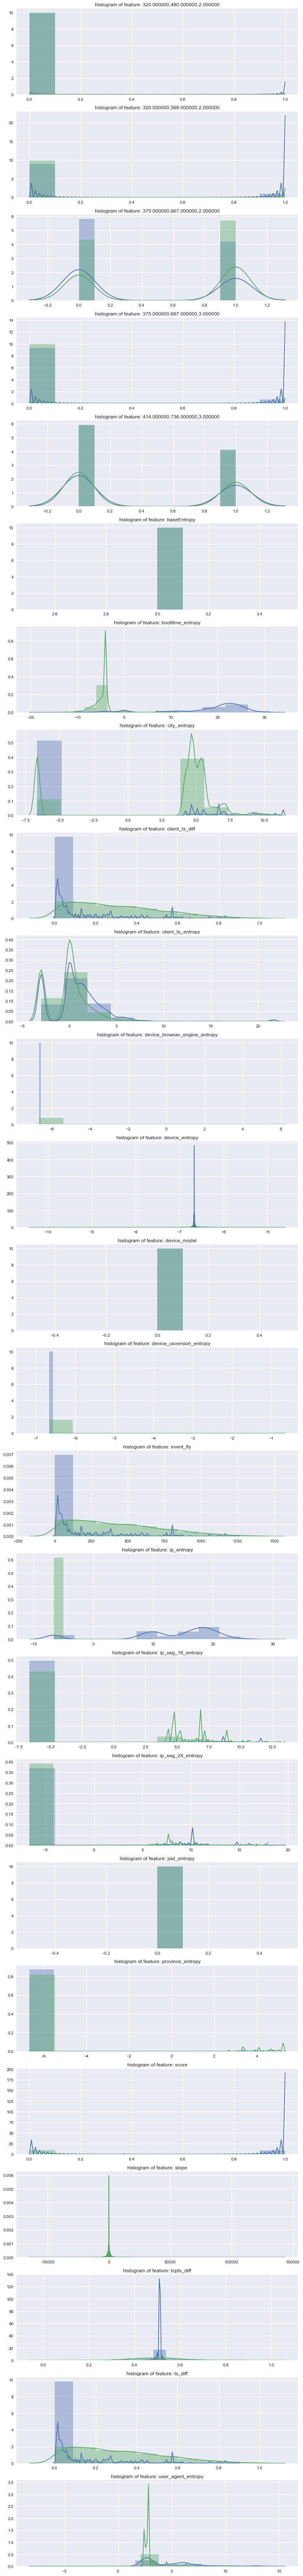

In [27]:
X = df_c[cols]
y = df_c.ix[:, df_c.columns == 'label']
v_features = cols
pic_nums = v_features.shape[0]
import matplotlib.gridspec as gridspec
plt.figure(figsize=(12,28*4))
gs = gridspec.GridSpec(pic_nums, 1)
for i, cn in enumerate(df_c[v_features]):
    print("cn",cn)
    ax = plt.subplot(gs[i])
    sns.distplot(df_c[cn][df_c.label == 1], bins=10)
    sns.distplot(df_c[cn][df_c.label == 0], bins=10)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

In [30]:
drop_cols = ['baseEntropy',
              'device_model','jsid_entropy']

In [31]:
df_c = df_c.drop(drop_cols,axis=1)

In [32]:
df_c.columns

Index([              u'boottime_entropy',                   u'city_entropy',
                    u'client_ts_entropy',  u'device_browser_engine_entropy',
                       u'device_entropy',       u'device_osversion_entropy',
                            u'event_fly',                     u'ip_entropy',
                    u'ip_seg_16_entropy',              u'ip_seg_24_entropy',
                                u'label',               u'province_entropy',
                                u'score',                          u'slope',
                   u'user_agent_entropy',                 u'client_ts_diff',
                           u'tcpts_diff',                        u'ts_diff',
       u'320.000000,480.000000,2.000000', u'320.000000,568.000000,2.000000',
       u'375.000000,667.000000,2.000000', u'375.000000,667.000000,3.000000',
       u'414.000000,736.000000,3.000000'],
      dtype='object')

In [33]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
ts_match = re.compile('^.*ts_diff$')
ts_amatch = np.vectorize(lambda x:bool(ts_match.match(x)))
ts_cols = df_c.columns.values[ts_amatch(df_c.columns.values)]
ts_df_c = df_c[ts_cols]
ts_no = df_c[df_c.columns.difference(ts_cols)]

min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(ts_df_c)
ts_df_c = pd.DataFrame(X_scaled, columns = ts_df_c.columns)
df_c = pd.concat([ts_no, ts_df_c], axis=1)

In [34]:
def tick_font_new(ax=None,font_size=None,rotation=90):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(font_size)
        tick.label.set_rotation(rotation)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(font_size)
        tick.label.set_rotation(0)
    return None

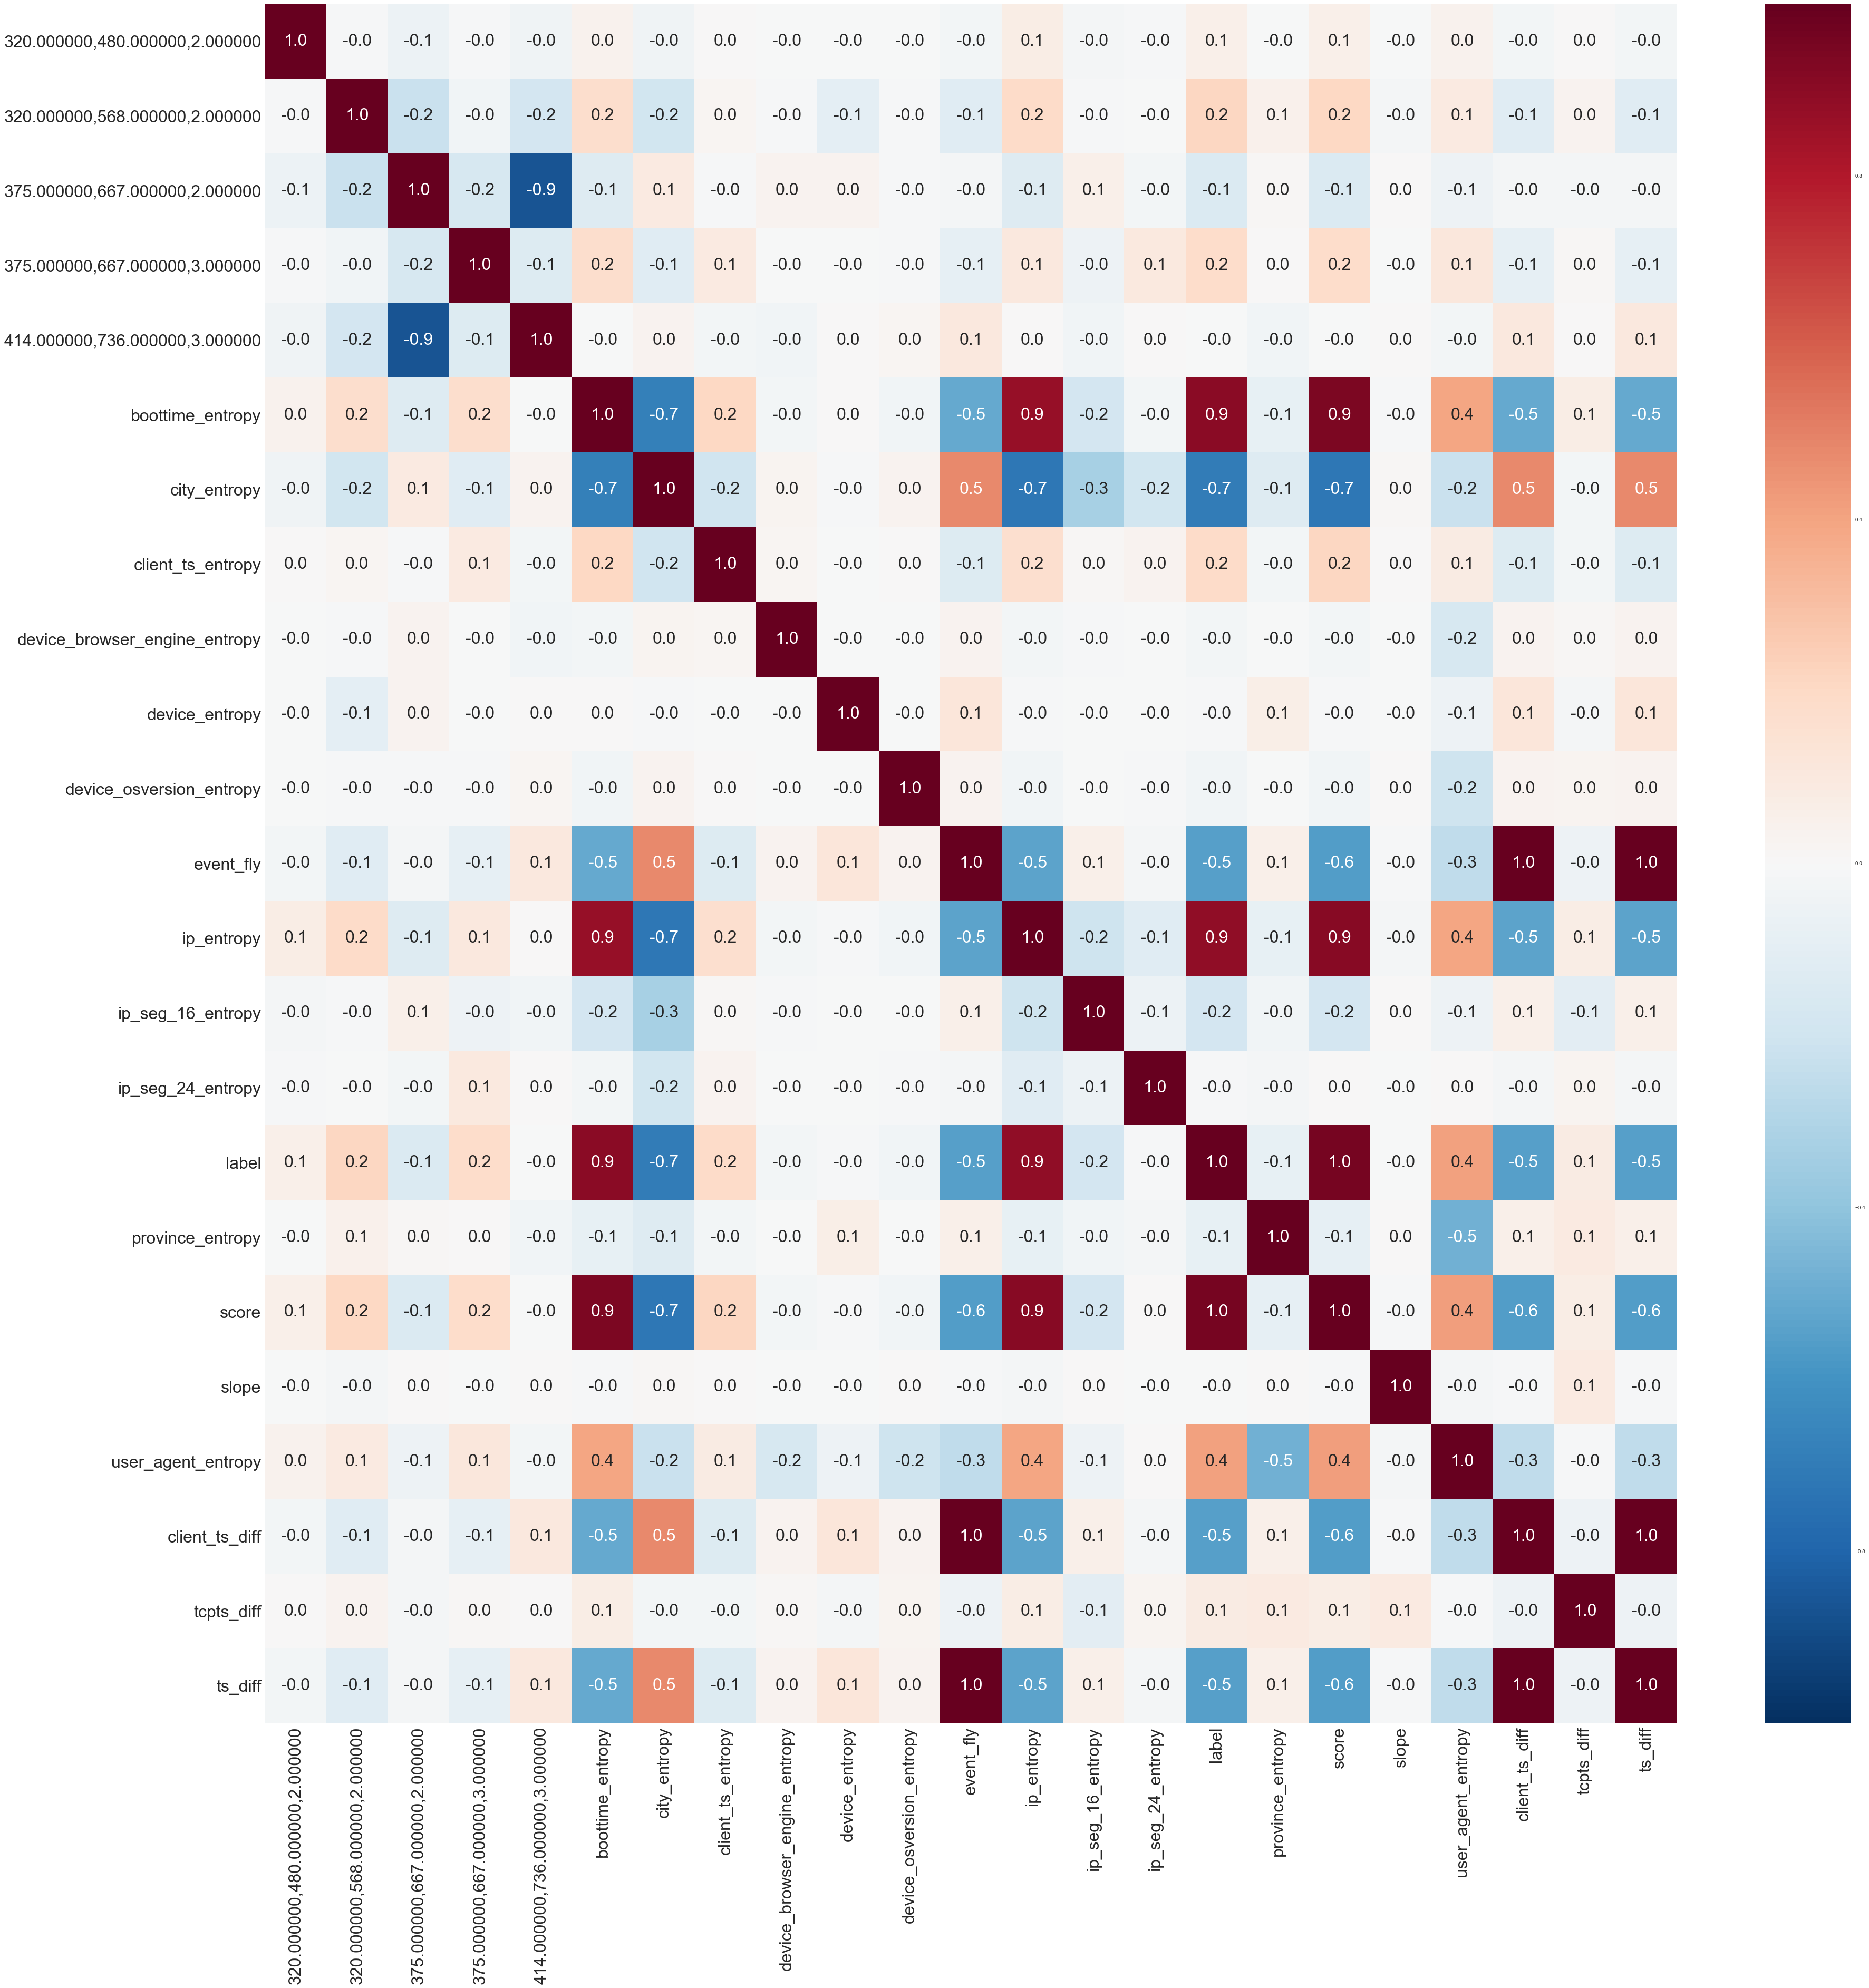

In [35]:
fig,ax= plt.subplots(figsize=(60,60))
sns.heatmap(df_c.corr(),ax=ax,annot=True,fmt='.1f',annot_kws={"size": 32})
tick_font(ax=ax,font_size=32,rotation_y=0)
plt.show()

In [36]:
df_c = df_c.drop(['ts_diff'],axis=1)

In [37]:
df_c.columns

Index([u'320.000000,480.000000,2.000000', u'320.000000,568.000000,2.000000',
       u'375.000000,667.000000,2.000000', u'375.000000,667.000000,3.000000',
       u'414.000000,736.000000,3.000000',               u'boottime_entropy',
                         u'city_entropy',              u'client_ts_entropy',
        u'device_browser_engine_entropy',                 u'device_entropy',
             u'device_osversion_entropy',                      u'event_fly',
                           u'ip_entropy',              u'ip_seg_16_entropy',
                    u'ip_seg_24_entropy',                          u'label',
                     u'province_entropy',                          u'score',
                                u'slope',             u'user_agent_entropy',
                       u'client_ts_diff',                     u'tcpts_diff'],
      dtype='object')

In [38]:
df_c.shape

(8368, 22)

In [40]:
# X = df_c_t[cols]
# y = df_c_t.ix[:, df_c_t.columns == 'label']
# v_features = cols
# pic_nums = v_features.shape[0]
# import matplotlib.gridspec as gridspec
# plt.figure(figsize=(12,28*4))
# gs = gridspec.GridSpec(pic_nums, 1)
# for i, cn in enumerate(df_c_t[v_features]):
#     print("cn",i,cn)
#     ax = plt.subplot(gs[i])
#     sns.distplot(df_c_t[cn][df_c_t.label == 1], bins=10)
#     sns.distplot(df_c_t[cn][df_c_t.label == 0], bins=10)
#     ax.set_xlabel('')
#     ax.set_title('histogram of feature: ' + str(cn))
# plt.show()

In [41]:
df_c.score.describe()

count    8368.000000
mean        0.351755
std         0.474217
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: score, dtype: float64

In [44]:
df_c.loc[df_c.score == 1.0].shape

(8368, 22)

In [43]:
df_c.shape

(8368, 22)

In [45]:
df_c.loc[df_c.score < 1.0].shape

(6220, 22)